# Googlenet/ InceptionNet

The Inception block is equivalent to a subnetwork with four paths. It extracts information
in parallel through convolutional layers of different window shapes and maximum pooling
layers. 1 × 1 convolutions reduce channel dimensionality on a per-pixel level. Maximum
pooling reduces the resolution.

• GoogLeNet connects multiple well-designed Inception blocks with other layers in series.
The ratio of the number of channels assigned in the Inception block is obtained through a
large number of experiments on the ImageNet dataset.

• GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.

**Also called GoogleNetv3, a famous ConvNet trained on Imagenet from 2015**

<img src="https://pytorch.org/assets/images/inception_v3.png" alt="alt" width="50%"/>

In [32]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [33]:
class Inception(nn.Module):
    def __init__(self,in_channels, c1, c2, c3, c4, debug=False, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
        self.debug = debug
        
    
    def forward(self, X, ):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        if (self.debug):
            print(p1.shape, p2.shape,p3.shape, p4.shape)
            
        return torch.cat((p1,p2,p3,p4), dim=1)

In [34]:
Z = torch.randn(1,1,224,224)

small_net = Inception(1, 84, (192, 384), (48, 128), 128, debug=True)

small_net(Z).shape

torch.Size([1, 84, 224, 224]) torch.Size([1, 384, 224, 224]) torch.Size([1, 128, 224, 224]) torch.Size([1, 128, 224, 224])


torch.Size([1, 724, 224, 224])

In [35]:
# lets build the network piece by piece
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
padding=1))


In [36]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [37]:
b3 = nn.Sequential(Inception(192,64, (96,128), (16,32), 32),
                   Inception(256,128, (128,192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                   

In [38]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [39]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (192, 384), (48, 128), 128),
                    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())


In [40]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024,10))

In [41]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [42]:
for layer in net:
    print(layer.__class__.__name__)


Sequential
Sequential
Sequential
Sequential
Sequential
Linear


In [43]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


This being done, we know it impossible (?) to train from scratch so we will use a pretrained model

# "Trying" to train

We take guidance from here: https://pytorch.org/hub/pytorch_vision_inception_v3/

it says that :

```
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 299. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
```

In [44]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
batch_size = 128
my_transforms = transforms.Compose(
                [
                    transforms.Resize(300),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

train_dataset = datasets.CIFAR10(download=True,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.CIFAR10(download=True, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## fine tuning an inception model

from https://github.com/pytorch/vision/issues/302

@jamiechoi1995 @MichaelLiang12, @TiRune is correct, inception_v3 has an aux branch, and if this is not disabled the forward function will return a tuple (see here), which when passed to the criterion will throw this error.

So you have two choices:

1. disable aux_logits when the model is created here by also passing aux_logits=False to the inception_v3 function.

2. edit your train function to accept and unpack the returned tuple here to be something like:

output, aux = model(input_var)

In [45]:
import torchvision.models as models

In [46]:
inception = models.inception_v3(aux_logits=False, pretrained=True)

In [47]:
inception.fc =  nn.Linear(in_features=2048, out_features=10, bias=True)

In [48]:
# inception.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2), bias=False)

In [49]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [50]:
for param in inception.parameters():
    param.requires_grad = False

In [51]:
for param in inception.fc.parameters():
    param.requires_grad=True

In [52]:
# for param in inception.parameters():
#     print(param.__class__.__name__, " : ", param.requires_grad)

In [53]:
def accuracy(y_hat,y):
    return (y_hat.argmax(1)==y).sum()

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
def full_accuracy(net, data_iter):
    net.eval()
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)

            total_acc += accuracy(y_hat, y)
            total_num += y.numel()
    
    return total_acc/total_num

In [56]:
def train_net(net):
    
    train_loss = []
    train_acc = []
    test_acc = []

    net= net.to(device)
    net.train()
    for epoch in range(num_epochs):

        acc_value = 0
        total_number = 0
        total_loss= 0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()
            acc_value += accuracy(outputs, labels)
            total_number += labels.numel()

        with torch.no_grad():

            print(f"\tEpoch {epoch} : Statistics: ")
            print(f'\tcurrent train loss : {total_loss} / {total_number} : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {acc_value}/{total_number} : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')


            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
    return train_loss, test_acc, train_acc

In [57]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [58]:
%%time
num_epochs=3
train_loss, test_acc, train_acc = train_net(inception)

	Epoch 0 : Statistics: 
	current train loss : 909.6816239356995 / 50000 : 0.01819363247871399
	current train acc : 5723/50000 : 0.11445999890565872
	current test acc : 0.13130000233650208
	Epoch 1 : Statistics: 
	current train loss : 901.2892100811005 / 50000 : 0.01802578420162201
	current train acc : 6459/50000 : 0.12917999923229218
	current test acc : 0.13130000233650208
	Epoch 2 : Statistics: 
	current train loss : 901.2962093353271 / 50000 : 0.01802592418670654
	current train acc : 6459/50000 : 0.12917999923229218
	current test acc : 0.13130000233650208
	Epoch 3 : Statistics: 
	current train loss : 901.2861149311066 / 50000 : 0.01802572229862213
	current train acc : 6459/50000 : 0.12917999923229218
	current test acc : 0.13130000233650208
	Epoch 4 : Statistics: 
	current train loss : 901.2848615646362 / 50000 : 0.018025697231292725
	current train acc : 6459/50000 : 0.12917999923229218
	current test acc : 0.13130000233650208
	Epoch 5 : Statistics: 
	current train loss : 901.290743589

finished


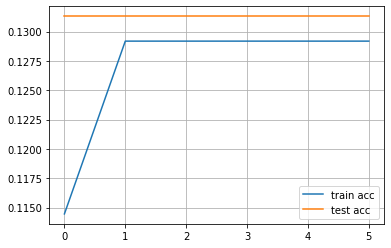

In [59]:
print("finished")

import matplotlib.pyplot as plt
num_epochs = num_epochs
# plt.plot(range(num_epochs), train_loss, label='train loss')
plt.plot(range(num_epochs), train_acc, label = 'train acc')
plt.plot(range(num_epochs), test_acc, label = 'test acc')
plt.grid(True)
plt.legend()
plt.show()

### Exercises

1. There are several iterations of GoogLeNet. Try to implement and run them. Some of them include the following:

    • Add a batch normalization layer (Ioffe & Szegedy, 2015), as described later in Section 7.5.
    https://arxiv.org/pdf/1502.03167v2.pdf
    
    https://stackoverflow.com/questions/37624279/how-to-properly-add-and-use-batchnormlayer#:~:text=BatchNormLayer%20should%20be%20added%20after%20the%20dense%20or,if%20you%20added%20BatchNormLayer%20after%20or%20convolution%2Fdense%20layer.
    
    • Make adjustments to the Inception block (Szegedy et al., 2016).
    
    • Use label smoothing for model regularization (Szegedy et al., 2016)

    • Include it in the residual connection (Szegedy et al., 2017), as described later in Section 7.6.

2. What is the minimum image size for GoogLeNet to work?

* I found out that it was around 299. from https://pytorch.org/hub/pytorch_vision_inception_v3/

it says that :

```
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 299. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
```
3. Compare the model parameter sizes of AlexNet, VGG, and NiN with GoogLeNet. How do the
latter two network architectures significantly reduce the model parameter size?

* GoogleNet has 22 layer, and almost 12x less parameters (So faster and less then Alexnet and much more accurate).
* without counting the aux it has 51668 parameters.
* function to calculate the parameters
```python
counter = 0

for param in inception.parameters():
    counter += len(param)
print(counter)
```

In [60]:
#3 

counter = 0

for param in inception.parameters():
    counter += len(param)
print(counter)
    

51668
